# CAPA online 

## Installation

To install the **capa_online** package from github using pip

 

```bash
python -m pip install 'git+https://github.com/grosed/capa_online/#egg=capa_online&subdirectory=package'
```

## Basic Usage

### use latest version from github

In [1]:
!python -m pip uninstall -y capa_online
!python -m pip install 'git+https://github.com/grosed/capa_online/#egg=capa_online&subdirectory=package'

Found existing installation: capa_online 1.1.1
Uninstalling capa_online-1.1.1:
  Successfully uninstalled capa_online-1.1.1
  Cloning https://github.com/grosed/capa_online/ to /tmp/pip-install-wj9w_u_p/capa-online_9cca228a108949819b62cff51794118a
  Running command git clone --filter=blob:none --quiet https://github.com/grosed/capa_online/ /tmp/pip-install-wj9w_u_p/capa-online_9cca228a108949819b62cff51794118a
  Resolved https://github.com/grosed/capa_online/ to commit 552575a7322362f5a3a1db6ba9b0f3193df45cdf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for capa_online: filename=capa_online-1.1.1-py3-none-any.whl size=3956 sha256=b7b81edc2f9c225904d189141db36737af72be95c81dff55ee98a7cd68c98a0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-crs0mhe7/wheels/38/97/24/8f3a0b13105a57d8452e1ff75281b050f0b4f31833200b81f7
Successfully built capa_online


### Example 1 - change in mean

#### Generate data 

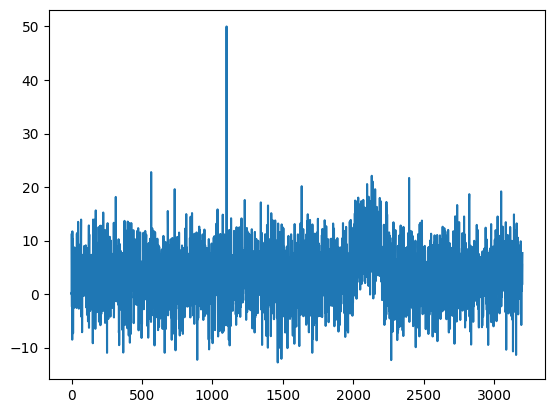

In [2]:
# create a simple example time series
import numpy as np

np.random.seed(1)
Z = [float(z) for z in list(np.random.normal(3, 5, 2000)) + 
    list(np.random.normal(10, 5, 200)) + # collective anomaly
    list(np.random.normal(3, 5, 1000))]
Z[1100] = 50 # point anomaly

# visualise the data
import matplotlib.pyplot as plt

plt.plot(Z)


#### Determine the underlying distribution using 1000 points for "burn in" period and create a transformer.

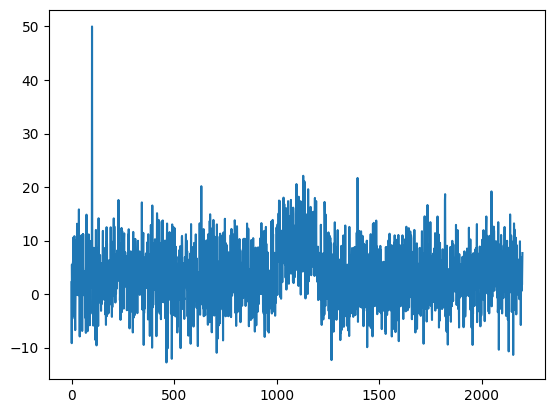

In [3]:
from capa_online import *
from statistics import mean,stdev

burn_in = Z[:1000]
transformer = scale(mean(burn_in),stdev(burn_in))

Z = Z[1000:]

plt.plot(Z)

#### Create a cost function with a window size of 500 and calculate penalties

In [4]:
from math import log
wsize = 500
cost = capa_normal_mean(wsize)
beta = 4*log(wsize)
beta_dash = 3*log(wsize)

#### Create a CAPA "scanner" from the cost and the transformer

In [5]:
scanner = compose(capa(cost,beta,beta_dash),transformer)

#### Simulate a stream of data using the time series, scan the data using CAPA, and store the change history.

In [6]:
history = list()
for z in Z :
    changes = scanner(z)
    history.append(changes)

In [7]:
history[100]

[99]

In [8]:
history[1399]

[(97, 293)]

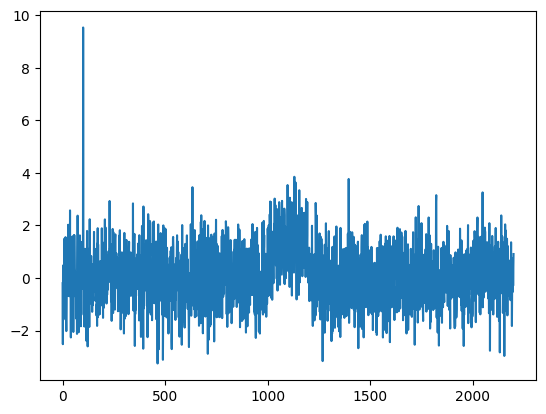

In [9]:
Y = [transformer(z) for z in Z]
plt.plot(Y)

#### Save results for plotting

In [10]:
import dill as pickle # needed to pickle closures
file = open('anomaly_history', 'wb')
pickle.dump((history,Z,wsize), file)
file.close()

#### Restarting

In [11]:
cost = capa_normal_mean(wsize)
scanner = compose(capa(cost,beta,beta_dash),transformer)

In [12]:
history = list()
for z in Z[:300] :
    changes = scanner(z)
    history.append(changes)

In [13]:
history[-1]

[99]

In [14]:
# save and delete
file = open('scanner','wb')
pickle.dump(scanner,file)
file.close()
del(scanner)

In [15]:
# reload
file = open('scanner', 'rb')
scanner = pickle.load(file)
file.close()

In [16]:
for z in Z[300:] :
    changes = scanner(z)
    history.append(changes)

In [17]:
history[1300]

[(196, 392)]

### Example 2 - change in mean and variance

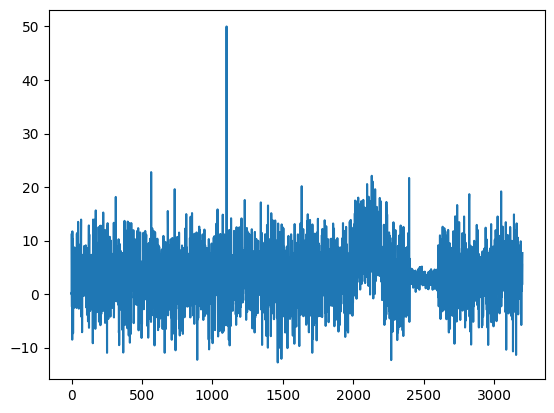

In [18]:
# create a simple example time series
import numpy as np

np.random.seed(1)
Z = [float(z) for z in list(np.random.normal(3, 5, 2000)) + 
    list(np.random.normal(10, 5, 200)) + # collective anomaly - change in mean
    list(np.random.normal(3, 5, 200)) + 
    list(np.random.normal(3, 1, 200)) + # collective anomaly - change in variance
    list(np.random.normal(3, 5, 600))]
Z[1100] = 50 # point anomaly

# visualise the data
import matplotlib.pyplot as plt

plt.plot(Z)

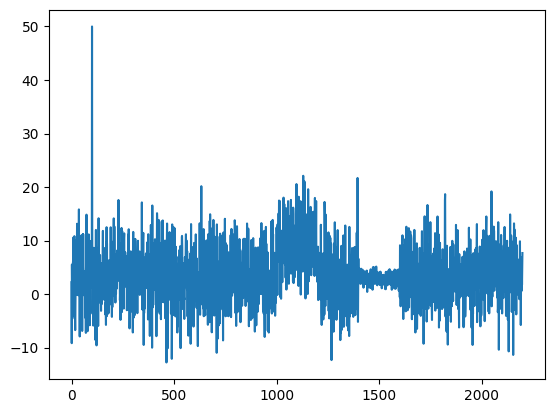

In [20]:
burn_in = Z[:1000]
transformer = scale(mean(burn_in),stdev(burn_in))

Z = Z[1000:]

plt.plot(Z)

#### Create a cost function with a window size of 500 and calculate penalties

In [34]:
wsize = 500
cost = capa_normal_mean_var(wsize)
beta = 4*log(wsize)
beta_dash = 3*log(wsize)

#### Create a CAPA "scanner" from the cost and the transformer

In [35]:
scanner = compose(capa(cost,beta,beta_dash),transformer)

In [36]:
history = list()
for z in Z :
    changes = scanner(z)
    history.append(changes)

In [39]:
history[1450]

[(46, 242)]